In [1]:
# Standard Imports
from pandas import Series, DataFrame
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
plt.rcParams['font.size'] = 14
import seaborn as sns
%matplotlib inline

In [2]:
# Performance
from time import time

In [3]:
# Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [26]:
# Helper
from sklearn.cross_validation import cross_val_predict, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV

# Preliminaries

In [5]:
# Load in the Data
train = pd.read_json('train.json')
test = pd.read_json('test.json')

In [6]:
train.head()

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


In [7]:
test.head()

,id,ingredients
0,18009,"[baking powder, eggs, all-purpose flour, raisi..."
1,28583,"[sugar, egg yolks, corn starch, cream of tarta..."
2,41580,"[sausage links, fennel bulb, fronds, olive oil..."
3,29752,"[meat cuts, file powder, smoked sausage, okra,..."
4,35687,"[ground black pepper, salt, sausage casings, l..."


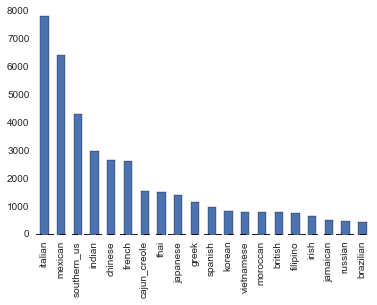

In [8]:
train.cuisine.value_counts().plot(kind = 'bar')

In [9]:
# null accuracy 

null_accuracy = train.cuisine.value_counts().max()/train.cuisine.count()

print("Null accuracy is", null_accuracy)

Null accuracy is 0.197063408257


In [10]:
# create hold-out set to determine accuracy of random forest
X_supvtrain, X_supvtest, y_supvtrain, y_supvtest = train_test_split(train["ingredients"], train["cuisine"])

## Feature extraction (text) ##

In [11]:
class featureExtraction(object):
    """
    cleanedText represents the text data that will be processed 
    """
    
    def __init__(self, data):
        """Assign raw data. Assumes dataframe """
        self.data = data
        
    def extractWords(self):
        """Extract the unique ingredients"""
        words = [' '.join(item) for item in self.data]
        return words
    
    def stem(self, words):
        stemmedTokens = [stemmer.stem(w) for w in words] 
        return stemmedTokens
    
    def vectorize(self, stemmedTokens, max_features=2500, ngram_range=(1,1), \
                  lowercase=True, stop_words=None, max_df=0.5, min_df= 10):
        """Tokenize, count, and weight the words"""
        vec = TfidfVectorizer(max_features=max_features, ngram_range=ngram_range, \
                              lowercase=lowercase, stop_words=stop_words, max_df=max_df, min_df= min_df)
        vec.fit(stemmedTokens)
        return vec
    
    def bag_of_words(self, vec, stemmedTokens):
        bag_of_words = vec.transform(stemmedTokens).toarray()
        return bag_of_words

In [12]:
# clean training data
text = featureExtraction(X_supvtrain)
words_train = text.extractWords()
stemmed_train = text.stem(words_train)
vec = text.vectorize(stemmed_train, max_features=2000, ngram_range=(1,1), \
               lowercase=True, stop_words=None, max_df=0.15, min_df= 5)
bow_train = text.bag_of_words(vec, stemmed_train)
bow_train.shape

(29830, 1837)

In [13]:
# clean test data
text = featureExtraction(X_supvtest)
words_supvtest = text.extractWords()
stemmed_supvtest = text.stem(words_supvtest)
bow_supvtest = text.bag_of_words(vec, stemmed_supvtest)
bow_supvtest.shape

(9944, 1837)

# Feature selection

In [24]:
# poor performance

# selector = SelectPercentile(f_classif, percentile = 10)
# selector.fit(bow_train, y_supvtrain)
# new_bow_train = selector.transform(bow_train)
# new_bow_supvtest = selector.transform(bow_supvtest)

# Hyper-parameter tuning
**Goal**: select best number of estimators for random forest

## *Randomized grid scores*

In [36]:
# specify parameters and distributions to sample from
from scipy.stats import randint as sp_randint

# build classifier
clf = RandomForestClassifier(n_estimators=20)

param_dist = {#"max_depth": [3, None],                  # None better
              "max_features": sp_randint(10, 20),        # higher better
              #"min_samples_split": sp_randint(1, 11),    # lower
              "min_samples_leaf": sp_randint(1, 11),    # lower?
              #"bootstrap": [True, False], 
              #"criterion": ["gini", "entropy"]          # entropy
              }        

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search)

start = time()
random_search.fit(bow_train, y_supvtrain)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))

RandomizedSearchCV took 234.38 seconds for 20 candidates parameter settings.


In [37]:
for params, mean_score, scores in random_search.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() * 2, params))

0.587 (+/-0.007) for {'min_samples_leaf': 8, 'max_features': 13}
0.587 (+/-0.014) for {'min_samples_leaf': 10, 'max_features': 15}
0.673 (+/-0.005) for {'min_samples_leaf': 2, 'max_features': 18}
0.647 (+/-0.006) for {'min_samples_leaf': 3, 'max_features': 17}
0.595 (+/-0.006) for {'min_samples_leaf': 10, 'max_features': 17}
0.583 (+/-0.017) for {'min_samples_leaf': 10, 'max_features': 13}
0.601 (+/-0.008) for {'min_samples_leaf': 5, 'max_features': 12}
0.580 (+/-0.010) for {'min_samples_leaf': 10, 'max_features': 13}
0.600 (+/-0.017) for {'min_samples_leaf': 8, 'max_features': 16}
0.589 (+/-0.008) for {'min_samples_leaf': 10, 'max_features': 16}
0.631 (+/-0.000) for {'min_samples_leaf': 5, 'max_features': 18}
0.582 (+/-0.006) for {'min_samples_leaf': 6, 'max_features': 10}
0.610 (+/-0.005) for {'min_samples_leaf': 4, 'max_features': 11}
0.615 (+/-0.002) for {'min_samples_leaf': 8, 'max_features': 19}
0.576 (+/-0.010) for {'min_samples_leaf': 8, 'max_features': 11}
0.594 (+/-0.010) for

In [38]:
best_parameters = random_search.best_estimator_.get_params()
for param_name in sorted(param_dist.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

	max_features: 18
	min_samples_leaf: 2


In [ ]:
# 	bootstrap: False
# 	criterion: 'entropy', 'entropy'
# 	max_depth: None
# 	max_features: 9, 10, 11, 18
# 	min_samples_leaf: 1, 1, 1, 2
# 	min_samples_split: 7, 1, 8

In [42]:
param_range = [1, 30, 40, 50]
tree_scores = []
for param_num in param_range:
    clf = RandomForestClassifier(n_estimators = 20, max_features = param_num)
    scores = cross_val_score(clf, bow_train, y_supvtrain, cv = 5, scoring = 'accuracy')
    tree_scores.append(scores.mean())

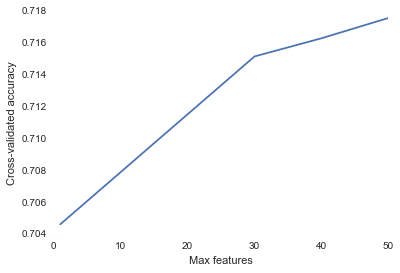

In [43]:
# plot scores for tree #'s
plt.plot(param_range, tree_scores)
plt.xlabel("Max features")
plt.ylabel("Cross-validated accuracy")

## Model selection ## 

Build a forest of trees from the training set (X, y)

In [44]:
start = time()
clf1 = RandomForestClassifier(n_estimators = 100)
print(cross_val_score(clf1, bow_train, y_supvtrain, cv = 10, scoring = 'accuracy').mean())
print("RandomForest Training finished in %.2f s" % (time() - start))

0.739087733792
RandomForest Training finished in 634.01 s


In [ ]:
#  0.731345214181 with 40 estimators
# 0.739087733792 with 100 estimators

In [17]:
start = time()
clf2 = LogisticRegression()
print(cross_val_score(clf2, bow_train, y_supvtrain, cv = 10, scoring = 'accuracy').mean())
print("Log Regression Training finished in %.2f s" % (time() - start))

0.764965899233
Log Regression Training finished in 52.90 s


In [ ]:
#  0.764965899233

##Model evaluation



##Hold-out test set


In [20]:
# Test the Prediction
clf1.fit(bow_train, y_supvtrain)
forest_pred = clf1.predict(bow_supvtest)
print("Accuracy: ", accuracy_score(forest_pred, y_supvtest))

Accuracy:  0.732401448109


In [21]:
# Test the Prediction
clf2.fit(bow_train, y_supvtrain)
log_pred = clf2.predict(bow_supvtest)
print("Accuracy: ", accuracy_score(log_pred, y_supvtest))

Accuracy:  0.762972646822
